  #### Basic Sentiment Analysis (2018)
The following notebook conducts sentiment analysis on data collected from the 2015 Canadian political election. It uses a pre-determined set of words classified with a sentiment as training set that is used to traing a logisitic regression model. This model is used to determine the sentiment of the unclassified political related tweets from the Canadian election. These tweets are used to gauge the sentiment towards specific parties within the election and is compared to the actual result of the election.

The notebook starts with cleaning of the data and seperating the tweets into parties. Some exploration of the data is conducted via charts which leads into the model preparation.

In [4]:
#Install Some Required Libraries
!pip install 'tqdm';
!pip install 'wordcloud';

import nltk 
#Download Required NLTK Files
nltk.download('stopwords');
nltk.download('english');
nltk.download('punkt');

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/notebook/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading english: Package 'english' not found in
[nltk_data]     index
[nltk_data] Downloading package punkt to /home/notebook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import sklearn as skl
import nltk 
import sys
import os
from nltk.corpus import stopwords

import re #Regular expression handling
from tqdm import tqdm
import html
import string
from string import punctuation
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import seaborn as sb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scipy.stats
from sklearn.model_selection import learning_curve
    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

%matplotlib inline

#Define Learning Curve  Function
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,\
                        train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    
    plt.figure(figsize=(10,6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt


## 0. Read in Files

Reading in the files is quite straight forward. I use pandas library to read the classified and unclassified tweets because the data will be useful to examine in a dataframe. The stop_words is also read using the pandas library but is converted into an array and flattened to have an array of just text words which will be used later to remove stop words.

I originally used the built in open function in pythin to open a text file then dynamically read each line into an array using a for loop. This was code heavy for the task and using pandas reduced the number of operations required and simplified the task.

In [6]:
# Read in Classfied Tweets
classified = pd.read_csv("classified_tweets.txt", usecols=['class', 'text'])

In [7]:
#Read in Unclassified Tweets
unclassified = pd.read_csv("unclassified_tweets.txt", header=None, sep="\n",  names = ["text"])

In [8]:
#Read in Stop Words
stop_words = pd.read_csv("stop_words.txt", header=None, sep="\n",  names = ["word"])
stop_words = stop_words.values.flatten().tolist()

#Use NLTK Stop Words List Combined with Provided Stop Words List
stop_words = stopwords.words('english') + list(string.punctuation) + stop_words + ['time'] + ["n't"] + ['going'];

In [9]:
#Read in Corpus
corpus = pd.read_csv("corpus.txt", sep="\s+-", names=['word', 'class'], engine='python', )
corpus = corpus.dropna()
corpus_words = corpus.word.values.flatten().tolist()

## 1. Data Cleaning

Cleaning tweet data requires looping through each tweet and removing unmwanted characters. First, we must know what chracters we want to remove and to build a regular-expression (REGEX) to compare against each tweet line. 

Furthermore, removing the stopwords requires to check eaxh word against all stopwords in the stopwords list. The stopword list is built from the NLTK library and combined with the provided stop-words list for this assignment. To remove a stop word, each word in a tweet is tokenized using the NLTK tokenizer and each word run through a for loop. If a word in the tweet is also in the stopwords list it is ignored. The new tweet is built keeping the words not in the list and is de-tokenized and placed back into a dataframe for conveinent viewing.  

A function is designed to clean the tweets with many sub proceudres for performing different functions on the tweet.  The following is performed,

        1. Remove HTML tags, URL's and Punctuation
        2. Lowercase all text
        3. Convert special chracters to ASCII
        4. Tokenize and Remove Stop Words        

In [10]:
def clean_tweets(tweet_input, stop_words):
    '''
    This function removes characters and words from an inputted line of text. 
    The input is a pandas dataframe of tweets with each tweet on its own line with column header 'text'.
    The output is a pandas dataframe of tweets with each cleaned tweet on its own line with column header 'text'.
    '''
    
    #Loop Through All Lines 
    for x, line in tqdm(enumerate(tweet_input.text)):

        #Remove HTML Tags & URLs (https://mathiasbynens.be/demo/url-regex)
        html_regex = r'\b((?:[a-z][\w-]+:(?:\/{1,3}|[a-z0-9%])|@|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}\/?)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\)){0,}(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s\!()\[\]{};:\'\"\.\,<>?«»“”‘’‘’]){0,})'
        line = re.sub(html_regex, "", line)
        line = re.sub('[^A-Za-z0-9]+ ', ' ', line)

        #Convert Special Chracters to ASII
        line= html.unescape(line)

        #Tokenize Line & Remove Stop Words
        tokens = nltk.word_tokenize(line)
        line2 = [word for word in tokens if word not in stop_words]   #https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

        # Detokenize
        line2 = "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in line2]).strip()
      
        #To Lowercase
        line3 = line2.lower().strip("^")
       
        #Replace in Dataframe
        tweet_input.set_value(x,'text', line3)
        
    return tweet_input  

In [11]:
#Clean Classified Tweets - This is slow on DataScientist Workbench = 1.5 minutes at 2500 it/s
classified_clean = clean_tweets(classified, stop_words)
classified_clean.head()

200000it [01:22, 2419.26it/s]


,class,text
0,0,switchfoot awww's bummer you shoulda david car...
1,0,upset update facebook texting cry result schoo...
2,0,kenichan i dived times ball managed save 50 th...
3,0,body feels itchy fire
4,0,nationwideclass's behaving'm mad i


In [12]:
#Clean Un-Classfied Tweets
unclassified_clean = clean_tweets(unclassified, stop_words)
unclassified_clean.head()

3026it [00:01, 2208.39it/s]


,text
0,﻿living dream cameraman camera cameraception c...
1,justin trudeau's reasons thanksgiving today's ...
2,themadape butt…..butt…..we’re allergic latex s...
3,2 massive explosions peace march turkey 30 kil...
4,mulcair suggests there’s bad blood trudeau rea...


## 2. Exploratory Analysis


The following procedures determines the affiliation of a politial party to a given tweet from the uncllassified tweet set.

To do this, a list of relevant words for each party is constructed from reserach of the party, examining the tweets that contain the party leaders names and general knowledge of canadian politics.

Each tweet is examined to see if any of the poltically affiliated words exist in that tweet. The function constructed will count the number of each political word in each tweet. The highest number of political words in that tweet results in assigned that tweet to the particualr party with the highest count. If there is a tie for the number of political words in a tweet, then that tweet is assigned to both parties. 

Top Canadian Political Parties (https://en.wikipedia.org/wiki/Politics_of_Canada)
1. Liberal
2. Conservative
3. New Democratic
4. Green           - Very few tweets determined to be for Green party. This party is ignored for the remainder of the analysis.


In [13]:
#Politically Affiliated Words
liberal_words = ['liberal','justin','trudeau','justintrudeau','annagainey','gainey','ralphgoodale','goodale',
                 'centre-left','center-left','left-wing','leftwing','liberalparty','realchange',
                 'teamtrudeau','willowdale','liberal','kathleen_wynne','mcguinty','lpc'];
conservative_words = ['harper','stephenharper','conservative','progressive','pc','cpc','tory',
                      'tories','pierrepoilievre','poilievre','oillievre','canadianvalues','pmharper', 'stevenharper',
                      'pmsh','votetory'];
ndp_words = ['ndp','mulcair','tommulcair','thomasmulcair','ready4change','tm4pm','socialism','votendp','plq'];

#Add Party Column to Unclassified Dataframe to Record Affiliation
unclassified_clean["party"] = ""

In [14]:
#Function to Assign Party to a Tweet
def select_party(tweets_in, liberal_words, conservative_words, ndp_words):
    '''
    This function compares inputted line of text to a know set of words. It will find how many times a word from 
    the given arrays appear in a line of text (a tweet). The function will check which count is the highest and if there is
    a tie. 
    The function inputs a pandas dataframe of tweets and sets of politially affiliated words
    The function outputs a pandas dataframe of tweets with a new column containing party affiliation
    '''

    #Initialize Empty Dataframe for New Tweet List
    new_tweets = pd.DataFrame(columns=['text','party']);

    #Loop Through each Tweet
    for i, tweet in enumerate(tweets_in.text):

        #Initialize Count Variables
        lbc_count = 0; cpc_count = 0; ndp_count = 0;

        #Search Each Tweet for Political Words and Count
        for x in range(len(liberal_words)): 
            if liberal_words[x] in tweet: lbc_count = lbc_count + 1;
        for x in range(len(conservative_words)):  
            if conservative_words[x] in tweet: cpc_count = cpc_count + 1;
        for x in range(len(ndp_words)): 
            if ndp_words[x] in tweet: ndp_count = ndp_count + 1;

        #Create Key/Value Pair of Party and Find Max Count
        party = {'Liberal':lbc_count, 'Conservative':cpc_count, 'NDP':ndp_count};
        highest = ([k for k, v in party.items() if v == max(party.values())])

        #Assign Party to Tweet, If Tie, Assign multiple parties to a tweet
        if (sum(party.values()) >= 1):
            for y in range(len(highest)):
                party = pd.DataFrame([[ str(tweet), str(highest[y]) ]],  columns=['text','party']);
                new_tweets = new_tweets.append( party, ignore_index=True );
        else: 
                party = pd.DataFrame([[ str(tweet), str('') ]],  columns=['text','party']);
                new_tweets = new_tweets.append( party, ignore_index=True );      
    return new_tweets;

With the above built function, a call is made to with the appropriate inputs. This only needs to be performed once to obtain the new list of tweets with poltiical affiliation attached in a new column

After this is performed, the tweets are split into new dataframes affiliated to specific parties. Lastly, the counts of each tweet to each party is visulaized to obtain some insight into the election. 

In [15]:
#Call Select_Party Function to Obtain Tweet List with Party Affiliation
new_tweets = select_party(unclassified_clean, liberal_words, conservative_words, ndp_words);

#Assign Dataframe for each Political Party Tweets (Reset Index Count Performed)
liberal_tweets = new_tweets[new_tweets['party'] == 'Liberal'].reset_index(drop=True);
cons_tweets = new_tweets[new_tweets['party'] == 'Conservative'].reset_index(drop=True);
ndp_tweets = new_tweets[new_tweets['party'] == 'NDP'].reset_index(drop=True);
other_tweets = new_tweets[new_tweets['party'] == ''].reset_index(drop=True);

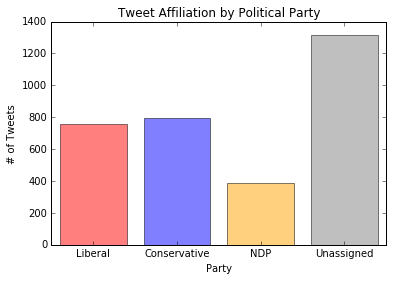

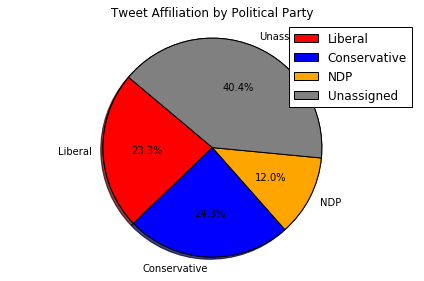

In [16]:
#Distribution of Political Affiliations of Tweets

#Bar Chaty
x = [1,2,3,4]
y = (int(len(liberal_tweets)),int(len(cons_tweets)),int(len(ndp_tweets)),int(len(other_tweets)))
#x = ('Liberal','Conservative','NDP','Unassigned')
plt.bar(x,y,align='center', alpha = 0.5, color=['r','b','orange','grey'])
plt.xticks(x, ('Liberal','Conservative','NDP','Unassigned'))
plt.xlabel('Party')
plt.ylabel('# of Tweets')
plt.title('Tweet Affiliation by Political Party')
plt.show()

#Pie Chart
labels = 'Liberal', 'Conservative', 'NDP', 'Unassigned'
sizes = [len(liberal_tweets), len(cons_tweets), len(ndp_tweets), len(other_tweets)]
colors = ['red', 'b', 'orange', 'grey']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Tweet Affiliation by Political Party')
plt.axis('equal')
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=140)
plt.legend(patches, labels, loc="best")
plt.tight_layout()
plt.show()

<u>DISCUSSION</u> <br>
The visualization of the data shows that the liberal and conservative parties had similar number of tweets to the party. These being the two strongest parties in Canada, this comes at no surprise. The NDP had half the amount of tweets then the other two main parties.

The 2015 election resulted in a seat distribution where Liberal has 39% of the seats, Conservatives 32% and NDP 20%. The number of tweets almost matches this, with the number of NDP tweets being half as many as the seats actually won.<br><br>

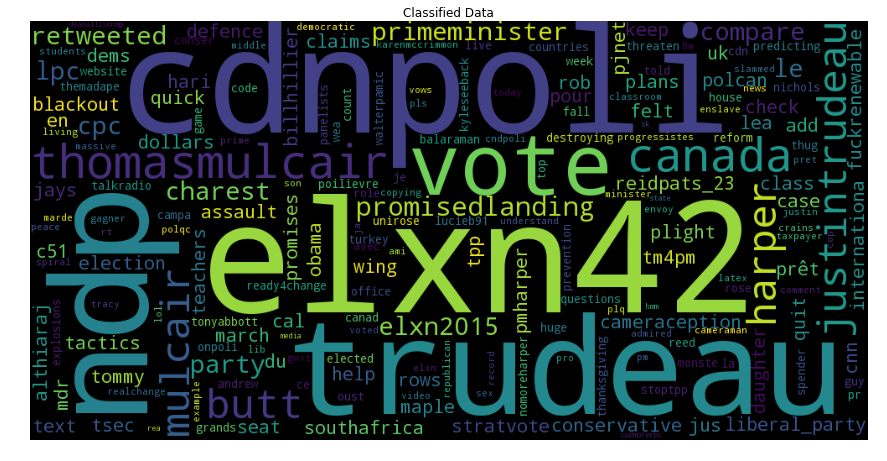

In [17]:
#Visualization of Unclassified Tweets
cloud = WordCloud(stopwords = stop_words, width = 1000, height = 500).generate(str(unclassified_clean))
plt.figure(figsize=(15,10))
plt.imshow(cloud)
plt.title('Classified Data')
plt.axis('off')
plt.show()   

<bR>The classified tweets are split into positive and negative tweet lists and placed into dataframes. These dataframes are used to create word clouds for positive words and negative words to help visualize the content. <br><br>

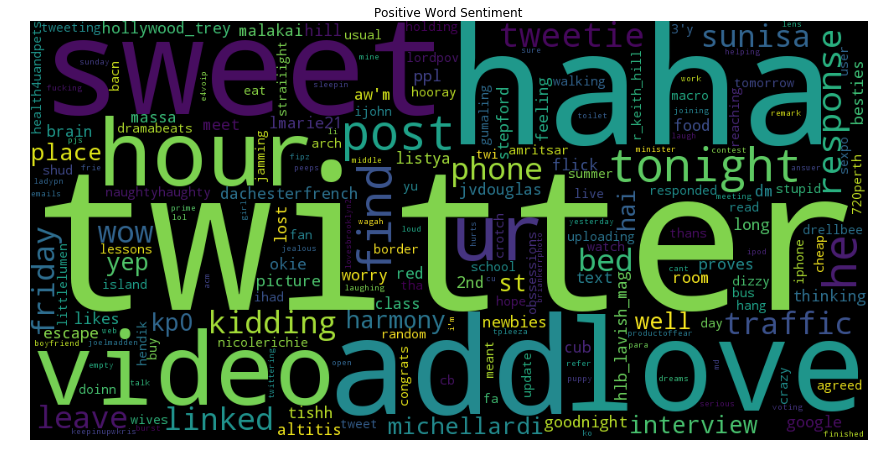

In [18]:
#Visualization of Classified Tweets - Positive and Negative Tweets
positive_tweet  = classified_clean[classified_clean['class'] == 4];
negative_tweet = classified_clean[classified_clean['class'] == 0];

#Word Cloud of Positive Tweets
cloud = WordCloud(stopwords = stop_words, width = 1000, height = 500).generate(str(positive_tweet))
plt.figure(figsize=(15,10))
plt.imshow(cloud)
plt.title('Positive Word Sentiment')
plt.axis('off')
plt.show()    

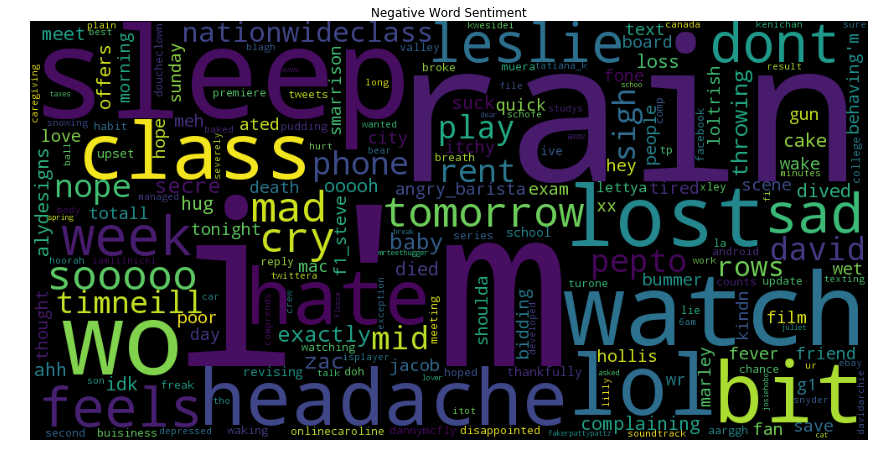

In [20]:
#Word Cloud of Negative Tweets
cloud = WordCloud(stopwords = stop_words, width = 1000, height = 500).generate(str(negative_tweet))
plt.figure(figsize=(15,10))
plt.imshow(cloud)
plt.title('Negative Word Sentiment')
plt.axis('off')
plt.show() 

<u>ANALYSIS</u> <br>
After examining the word clouds, there was punctuation and other common words between both positive and negative word clouds that needed to be removed. These items were added to the stop word list at the start and the tweets re-cleaned. This cleaned up the word clouds and presented more obvious words that were negative and positive. 

The word clouds provide insight into what words we could expect in a tweet for it to be positive or negative. 

<b>Strong Positive Words:</b> Love, Haha, Twitter and Sweet<br>
<b>Strong Negative Words:</b> Sleep, Rain, Cry and Feels

<br>

## 3. Model Preparation - Sentiment Analysis

A model will be trained from the set of classified tweets and the correpsonding sentiment value (0 or 4) to build a model for sentiment analysis of tweets. 

The set of unclassified tweets is split 70/30 into traing and testing data usinf sklearn library. Pre-processing and cleaning of the tweets has already been performed earlier in this notebook. Logisitic Regression is the model training method that will be used with an output value of positive or negative for a tweet.

The classified tweets are preapred into two lists. One for the class values and one for the text of the tweet. This is ncessary to vectorize the data for input into logistic regression algorithm.

The method used to define the features of the model will be the frequency of each word method through TF-IDF vetcorization. 

TF-IDF is Term Frequency-Inverse Document Frequency. It determines how important a word is to the document (tweet). It produces a weighting factor of each word in a tweet to the importance of it to the class. The more the word appears in the tweets the higher it's weighting. This is the most common term-weighting schemes being used today.<br><br>

In [21]:
#Prepare Sentiment Class Data into List
sent_class = classified_clean['class'].as_matrix().tolist();

#Prepare Classified Tweet Text into List
list_classified_tweets = classified_clean.text.values.flatten().tolist()

#Vectorize Classified Tweets into Feature Space
vectorizer = TfidfVectorizer(sublinear_tf=True,  max_df=0.7)
classified_vector = vectorizer.fit_transform(list_classified_tweets)

In [22]:
#Split Classified Data into Training & Testing Set
feature_train, feature_test, sent_train, sent_test = train_test_split(classified_vector, sent_class, test_size=0.3)

In [23]:
#Create Logisitic Regression Model for Unclassified Tweets
reg_model = LogisticRegression();

#Train the Model on Training Sets
classified_model = reg_model.fit(feature_train, sent_train);

#Predict with Test Set to Test Model
sent_pred = classified_model.predict(feature_test);

[[21653  8319]
 [ 6421 23607]]


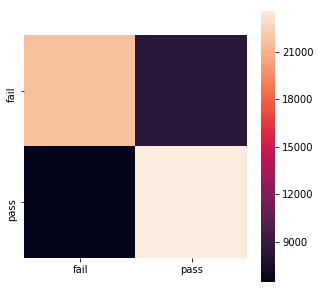

In [20]:
#Create a Confusion Matrix
conf_matrix = confusion_matrix(sent_test, sent_pred);
print(conf_matrix)

fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.set_aspect(1)
sb.heatmap(conf_matrix)
ax.set_xticklabels(['fail','pass'])
ax.set_yticklabels(['fail','pass']);

In [24]:
#Accuracy of Model
model_accuracy = classified_model.score(feature_test, sent_test);
print('Accuracy of Logistic Regression: {:.2f}'.format(model_accuracy));

Accuracy of Logistic Regression: 0.75


In [25]:
#Model Statistics
print(classification_report(sent_test, sent_pred))

             precision    recall  f1-score   support

          0       0.78      0.72      0.75     30056
          4       0.74      0.79      0.76     29944

avg / total       0.76      0.75      0.75     60000



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>

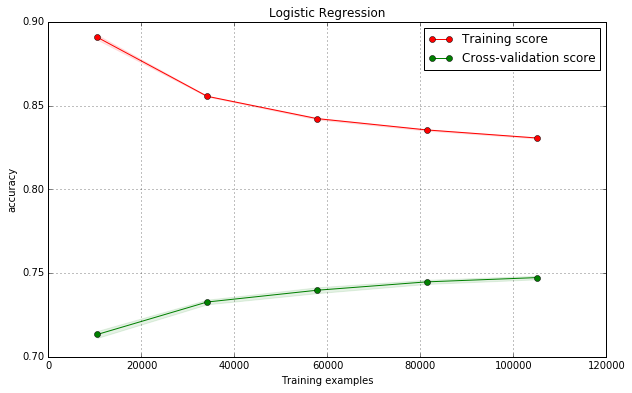

In [26]:
#Plot Results of Logisitic Regression
plot_learning_curve(classified_model, 'Logistic Regression', feature_train, sent_train, cv=4)

<u>DISCUSSION</u><br>
The logistic regression model was trained with the training data and then tested for accuracy with the test data set. The resulting outcome was a model with approximately a 75% accuracy in predicting the sentiment of a tweet. 

This is an acceptable result at this time. An improved set of sentiment classification tweets and more complex training and testing data set splitting such as k-folds could improve the training. <br>

The learning curve shows a large difference between the training and cross-validation. Although it appears that adding more samples (tweets) may converge the two lines, it looks like a lot more data would be required for convergence. So adding more data more only have a matginally better affect at imprving the accuracy of the model. However, convergence is likely to take place around the 80% point, still a somewhat low score.

#### Prepare Unclassified Political Tweets for Testing

Now that a trained model for sentiment analysis exists, the unclassified political tweets can be prepared to be classified using the model. The tweets are prepared as before, turned into lists and vectorized with TF-IDF Vectorizer. 

In [27]:
#Place Political Tweets in Array
liberal_tweets_arr = liberal_tweets.text.values.flatten().tolist()
cons_tweets_arr = cons_tweets.text.values.flatten().tolist()
ndp_tweets_arr = ndp_tweets.text.values.flatten().tolist()

In [28]:
#Vectorize Each Political Tweet Set
liberal_vector = vectorizer.transform(liberal_tweets_arr)
cons_vector = vectorizer.transform(cons_tweets_arr)
ndp_vector = vectorizer.transform(ndp_tweets_arr)

## 4. Model Implementation

To implement the model, the prepared unclassified political tweets are placed into the trained sentiment analysis model using the predict function. The results are visulaized on a single figure to show the number of negative and positive tweets per political party.<br><br>

In [29]:
#Use Sentiment Analysis Model Above to Test Sentiment of Each Tweet
liberal_pred = classified_model.predict(liberal_vector);
cons_pred = classified_model.predict(cons_vector);
ndp_pred = classified_model.predict(ndp_vector);

In [30]:
#Count the Negative and Positive Tweet Per Party & Calculate the Positve/Negative Ratio
lib_pos = liberal_pred.tolist().count(4)
lib_neg = liberal_pred.tolist().count(0)
lib_ratio = lib_pos/lib_neg;

con_pos = cons_pred.tolist().count(4)
con_neg = cons_pred.tolist().count(0)
con_ratio = con_pos/con_neg;

ndp_pos = ndp_pred.tolist().count(4)
ndp_neg = ndp_pred.tolist().count(0)
ndp_ratio = ndp_pos/ndp_neg;

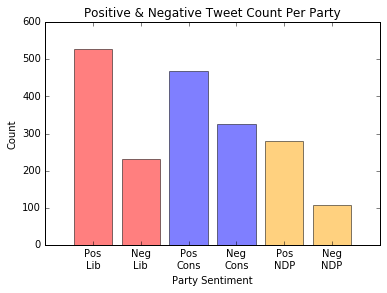

In [31]:
#Plot Tweet Sentiment per PArty
x = [1,2,3,4,5,6]
y = [lib_pos,lib_neg, con_pos, con_neg, ndp_pos, ndp_neg]
plt.bar(x, y, align='center', alpha=0.5, color=['r','r','b','b','orange','orange'])
plt.xticks(x, ('Pos\nLib','Neg\nLib','Pos\nCons','Neg\nCons','Pos\nNDP','Neg\nNDP'))
plt.ylabel('Count')
plt.xlabel('Party Sentiment')
plt.title('Positive & Negative Tweet Count Per Party')
plt.show()

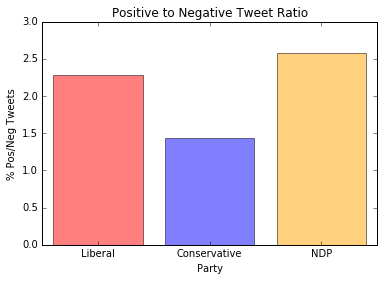

In [32]:
#Plot of Positive/Negative Ratio
x = [1,2,3]
y = [lib_ratio,con_ratio, ndp_ratio]
plt.bar(x, y, align='center', alpha=0.5, color=['r','b','orange'])
plt.xticks(x, ('Liberal','Conservative','NDP'))
plt.ylabel('% Pos/Neg Tweets')
plt.xlabel('Party')
plt.title('Positive to Negative Tweet Ratio')
plt.show()

## 5. Discussion

Examination of the results shows that all parties had more positive support then negative. People are more likely to tweet psoitive support of there party then to tweet negatively towards an alternative party. This can also be attributed to the polite Canadian cultural behavior. 

By calcualting the ratio of positive tweets to negative tweets it can be seen that the Liberal party and NDP party both had similar ratios and the conservatives way behind. Even though Liberal and NDP each have strong positive sentiment, the Liberal party has almost twice as many tweets and it can be inferred that the Liberal party has the larger support base over NDP. The conservative party on the other hand had significantly less positive sentiment then the other parties. During the 2015 election there was hestiation to re-elect the Conservatives due to a multitude if negative internal affairs the party was involved in. The tweet sentiment ratio is indicative of the Canadian peoples opinions at this time. 

Overall, the Liberal and Conservatives had the highest number of tweets (almost identical) which is indicative of the actual political landscape here. Both parties had a high amount support but there difference in sentiment ratios is what makes the difference for the Liberal majority win. The NDP had a good level of positive support but they could not cut it in voting base numbers, inferred by the number of tweets which were much less then the dominant parties. 

Interestingly, the number of seats won by each party in 2015 closely follows the positive tweet numbers in this analysis.<br><br> 

<table>
    <tr><th>Party</th><th>Seats in House</th><th>Psotive Tweets</th></tr>
    <tr><td>Liberal</td><td align="center">39%</td><td align="center">41%</td></tr>
    <tr><td>Conservative</td><td align="center">32%</td><td align="center">38%</td></tr>
    <tr><td>NDP</td><td align="center">20%</td><td align="center">21%</td></tr>
</table>


<br>Using this tweet sentiment analysis during the 2015 election, before the vote, would have indicated the result. The tweet sentiment ratio combined with the support base numbers (number of tweets) indicated the outcome to a decent degree of accuracy.<br><br>
<u>Drawbacks</u><br>
The algorithm trains the model with an accuracy of 75%. Althoguh okay for a high level sentiment analysis, this is a low accuracy for a strong model. There is lots of room  left for discrepancy of the outcome. 

To improve the training accuracy of this model more training data could be collected, or tuning of the regression. There is also a large number of unassgiend political tweets, about 41% with this analysis. Improving the politically affiliated word list could better categorize the tweets which could lead to a better prediction outcome. 

## 6. Bonus

#### 1. Use Provided Corpus to Train Sentiment Model<br>
The resulting model accuracy using the provided corpus instead of the classified tweets results in a lower accuracy.
A similar result is found when combining the classified tweets with corpus list as well.

In [33]:
#Using the Given Corpus for Positive & Negative Words
corpus_class = corpus['class'].as_matrix().tolist()
corpus_vector = vectorizer.fit_transform(corpus_words)
feature2_train, feature2_test, sent2_train, sent2_test = train_test_split(corpus_vector, corpus_class, test_size=0.3)
reg_model = LogisticRegression();
classified_model = reg_model.fit(feature2_train, sent2_train);
sent_pred = classified_model.predict(feature2_test);
model_accuracy = classified_model.score(feature2_test, sent2_test);
print('Accuracy of Logistic Regression: {:.2f}'.format(model_accuracy));

Accuracy of Logistic Regression: 0.59


In [34]:
#Using the Given Corpus with Classified Tweets 
all_class = corpus['class'].as_matrix().tolist() + sent_class;
all_words = corpus_words + list_classified_tweets;
corpus_vector = vectorizer.fit_transform(all_words)
feature2_train, feature2_test, sent2_train, sent2_test = train_test_split(corpus_vector, all_class, test_size=0.3)
reg_model = LogisticRegression();
classified_model = reg_model.fit(feature2_train, sent2_train);
sent_pred = classified_model.predict(feature2_test);
model_accuracy = classified_model.score(feature2_test, sent2_test);
print('Accuracy of Logistic Regression: {:.2f}'.format(model_accuracy));

Accuracy of Logistic Regression: 0.75


Using the provided CORPUS as a sentiment training set for the logisitc regression model, the resulting accuracy was only 59% for the model. This is very poor and not a useful model. By using combing the corpus with the classified tweets, the resulting model was 75%. This is the same as just using the classsified tweets. The classified tweets are sufficient the train the model to a 75% accuracy.

#### 2. Using Alternative Classification Algorithms

In [ ]:
#Use SVM as a Classification Model
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge

#Split Classified Data into Training & Testing Set
feature_train, feature_test, sent_train, sent_test = train_test_split(classified_vector, sent_class, test_size=0.3)

#Create Logisitic Regression Model for Unclassified Tweets
reg_model = SVC(C=1.0, kernel='linear');

#Train the Model on Training Sets
classified_model = reg_model.fit(feature_train, sent_train);

#Predict with Test Set to Test Model
sent_pred = classified_model.predict(feature_test);

#Accuracy of Model
model_accuracy = classified_model.score(feature_test, sent_test);
print('Accuracy of Logistic Regression: {:.2f}'.format(model_accuracy));

The SVM model above provided a final accurcy of 56%. This method is not accurate for classfiying tweets given the provided information.

This method took more then 40 minutes to run with the given datasets with my current PC specifications. This model is much less efficient then logistic regression and did not perform a better job at classficiation. 

In [ ]:
#Decision Trees
#Split Classified Data into Training & Testing Set
feature_train, feature_test, sent_train, sent_test = train_test_split(classified_vector, sent_class, test_size=0.3)

#Create Logisitic Regression Model for Unclassified Tweets
reg_model = tree.DecisionTreeClassifier()

#Train the Model on Training Sets
classified_model = reg_model.fit(feature_train, sent_train);

#Predict with Test Set to Test Model
sent_pred = classified_model.predict(feature_test);

#Accuracy of Model
model_accuracy = classified_model.score(feature_test, sent_test);
print('Accuracy of Logistic Regression: {:.2f}'.format(model_accuracy));

The decision trees method did not complete a cycle with over 1 hour of operation time. This is an alternative method, along with Naive Bayes and Random Forest, which are not implemented here.